In [1]:
import requests
import os

import numpy as np
from sklearn import datasets
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
def print_image(plot, data, shape=(64, 64)):
    plot.imshow(np.flip(data.reshape(shape).T, 1), cmap=plt.get_cmap('gray'))
    plot.axis('off')

## Part 1. Implement PCA and Dual PCA algorithms

In [3]:
# PCA (with covariance implementation)

def my_pca(X):
    data = X
    data_mean = np.mean(X) # get the mean matrix
    A = data - data_mean  # data centralisation
    S = np.cov(A)  # get the covariance matrix
    eig_val,eig_vec= np.linalg.eig(S)  # get eigenvalue and eigenvecotr
    eig_val=np.sort(eig_val)[::-1] #sort the eigvalue descend
    return eig_val,eig_vec

# Test your implementation
# eigenvalue = [7.93954312 0.06045688]
# eigen vectors = [[ 0.83849224 -0.54491354]
#                  [ 0.54491354  0.83849224]]
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
X = X.T
val, vec = my_pca(X)
print(val)
print(vec)

[7.93954312 0.06045688]
[[ 0.83849224 -0.54491354]
 [ 0.54491354  0.83849224]]


In [4]:
# PCA (with SVD)

def my_dual_pca(X):
    data = X
    data_mean = np.mean(X) # get the mean matrix
    A = data - data_mean  # data centralisation
    U, Sigma, Vh = np.linalg.svd(A, 
    full_matrices=False, 
    compute_uv=True)
    eig_vec=U#get eigenvector
    eig_val=np.square(Sigma) / (len(X.T) - 1)   # get eigenvalue
    return eig_val,eig_vec

# Test your implementation
# eigenvalue = [7.93954312 0.06045688]
# eigen vectors = [[ -0.83849224 -0.54491354]
#                  [ -0.54491354  0.83849224]]
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
X = X.T
val, vec = my_dual_pca(X)
print(val)
print(vec)

[7.93954312 0.06045688]
[[-0.83849224 -0.54491354]
 [-0.54491354  0.83849224]]


## Part 2. Visualisation

In [5]:
#import the models
import pandas as pd
import numpy as np
from sklearn import preprocessing #scaling the data before performing PCA
import matplotlib.pyplot as plt 

In [6]:
# Import dataset
X = np.load('./Data/synthetic_data.npy', allow_pickle=True)

### a) plot the 2-D projection results

In [7]:
val,vec=my_pca(X)

In [8]:
eig=pd.DataFrame({"eig_value":val})
eig=eig.sort_values(by=["eig_value"], ascending=False) 
#get the total eigenvalue for each eigenvector
eig["eig_cum"] = (eig["eig_value"]/eig["eig_value"].sum()).cumsum()
#merge the dataframe for a better visualization
eig=eig.merge(pd.DataFrame(vec), left_index=True, right_index=True)
eig

,eig_value,eig_cum,0,1,2,3
0,1.058248,0.815485,0.876689,0.376974,-0.297585,0.027380
1,0.101772,0.893911,0.480903,-0.677330,0.555886,-0.030789
2,0.071816,0.949253,0.012098,-0.324731,-0.452148,-0.830641
3,0.065854,1.000000,0.001533,-0.541908,-0.630869,0.555281


In [9]:
#get the first 3 PC
PC = eig.iloc[:4,2:5]
PC

,0,1,2
0,0.876689,0.376974,-0.297585
1,0.480903,-0.677330,0.555886
2,0.012098,-0.324731,-0.452148
3,0.001533,-0.541908,-0.630869


In [10]:
#get normalized data
normalized_data = preprocessing.normalize(X)
#get dot product to transform the data into PC coordinates
score=pd.DataFrame(np.dot(normalized_data.T, PC))

In [11]:
tot = sum(val)# total eigenvalue
per_var = [(i / tot) for i in sorted(val, reverse=True)]# get the descending order of eigenvalues
per_var

[0.81548542300004,
 0.07842553588386607,
 0.05534166188693481,
 0.05074737922915921]

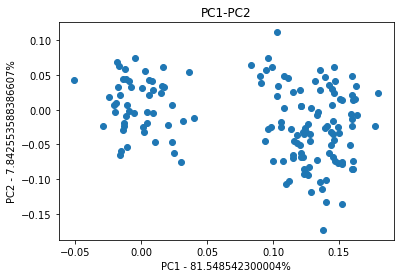

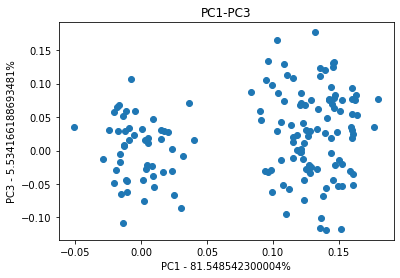

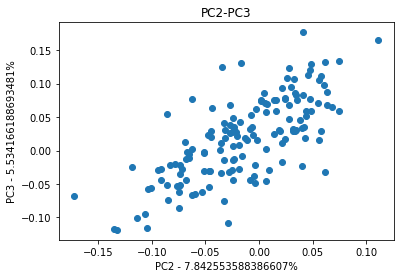

In [12]:
#plot data in 3 PCs
plt.scatter(score[0],score[1])
plt.title('PC1-PC2')
plt.xlabel('PC1 - {0}%'.format(per_var[0]*100))# x axis is PC1
plt.ylabel('PC2 - {0}%'.format(per_var[1]*100))# y axis is PC2
plt.show()
plt.scatter(score[0],score[2])
plt.title('PC1-PC3')
plt.xlabel('PC1 - {0}%'.format(per_var[0]*100))# x axis is PC1
plt.ylabel('PC3 - {0}%'.format(per_var[2]*100))# y axis is PC3
plt.show()
plt.scatter(score[1],score[2])
plt.title('PC2-PC3')
plt.xlabel('PC2 - {0}%'.format(per_var[1]*100))# x axis is PC2
plt.ylabel('PC3 - {0}%'.format(per_var[2]*100))# y axis is PC3
plt.show()

### b)describe any non-trivial properties you obeserve for this 4-D data set
A PCA plot shows clusters of samples based on their similarity. <br/>We can conclude that PC1 is the most important component, we can see that from PC1-PC2 plot and PC2-PC3 plot, the data was obviously separated into two classes, PC1 contributes the most variance which is 81.55%, followed by PC2 which is 7.84%. In the third graph, the data was not separated, they shows a linear correlation means PC2 and PC3 are not the optimal PC to classify the data.  


## Part 3. Image compression

In [13]:
X, _ = np.load(f'./Data/Yale_64x64.npy', allow_pickle=True)

_, num_examples = X.shape
test_sample = 0

test_indices =  np.arange(test_sample, num_examples, 11)
train_indices = np.delete(np.arange(num_examples), test_indices) 

train_X = X[:, train_indices]#150 images for achieving the PCA projection matrix
test_X = X[:, test_indices]# 15 images for evaluating the generalistion of the PCA learning

### a) how to decide a number of principal components 
The most straightforward approach to decide the number of principal components is by a scree plot. By observing the scree plot, and looking for a point at which the proportion of variance(POV) explained by each subsequent principal component drops off. 

### b) calculate the k by PoV method

In [14]:
val_train,vec_train=my_dual_pca(train_X)
# get total eigenvalue
tot = sum(val_train)
# get the descending order of eigenvalues
per_var = [(i / tot) for i in sorted(val_train, reverse=True)]

In [15]:
# this function is to return the k value for optimal numbers of pc
def pov(per_var):
    pov=0
    k=0
    for i in per_var:
        pov=pov+i
        if pov>0.9:
            break
        else:
            k=k+1
            continue
        break
    return k

In [16]:
print("The number of principal components k is:")
print(pov(per_var))

The number of principal components k is:
21


In [17]:
#v is an array to store the pov, this if for the plot in the next cell
v=[]
pov=0
for i in per_var:
        pov=pov+i
        v.append(pov)

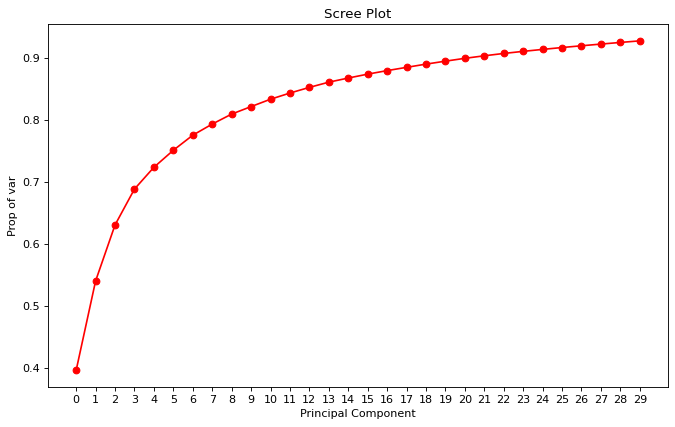

In [18]:
#from matplotlib import pyplot as plt


#import figure model to change the size of plot
from matplotlib.pyplot import figure
figure(figsize=(10, 6), dpi=80)
# store every PC accoriding to individual variance, in here we check the first 30 pcs
labels = [str(x) for x in range(0, 30)] 
plt.plot(labels,v[0:30],'ro-')
plt.ylabel('Prop of var')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

In the Scree Plot we could see that the POV is near 0.9 by around 20 PCs, this means using around 20 PCs can already establish a satisfactory image 

### c) display the k eigenface images 
In short, eigenfaces are eigenvecotrs. At previous cells I showed how to obtain the number of PCs(k). k is also the number of the eigenfaces

In [19]:
train_eigValInd=np.argsort(val_train)
train_index=np.argsort(val_train)
k_index=train_index[-21:]
eigenFaces=vec_train[:,k_index]

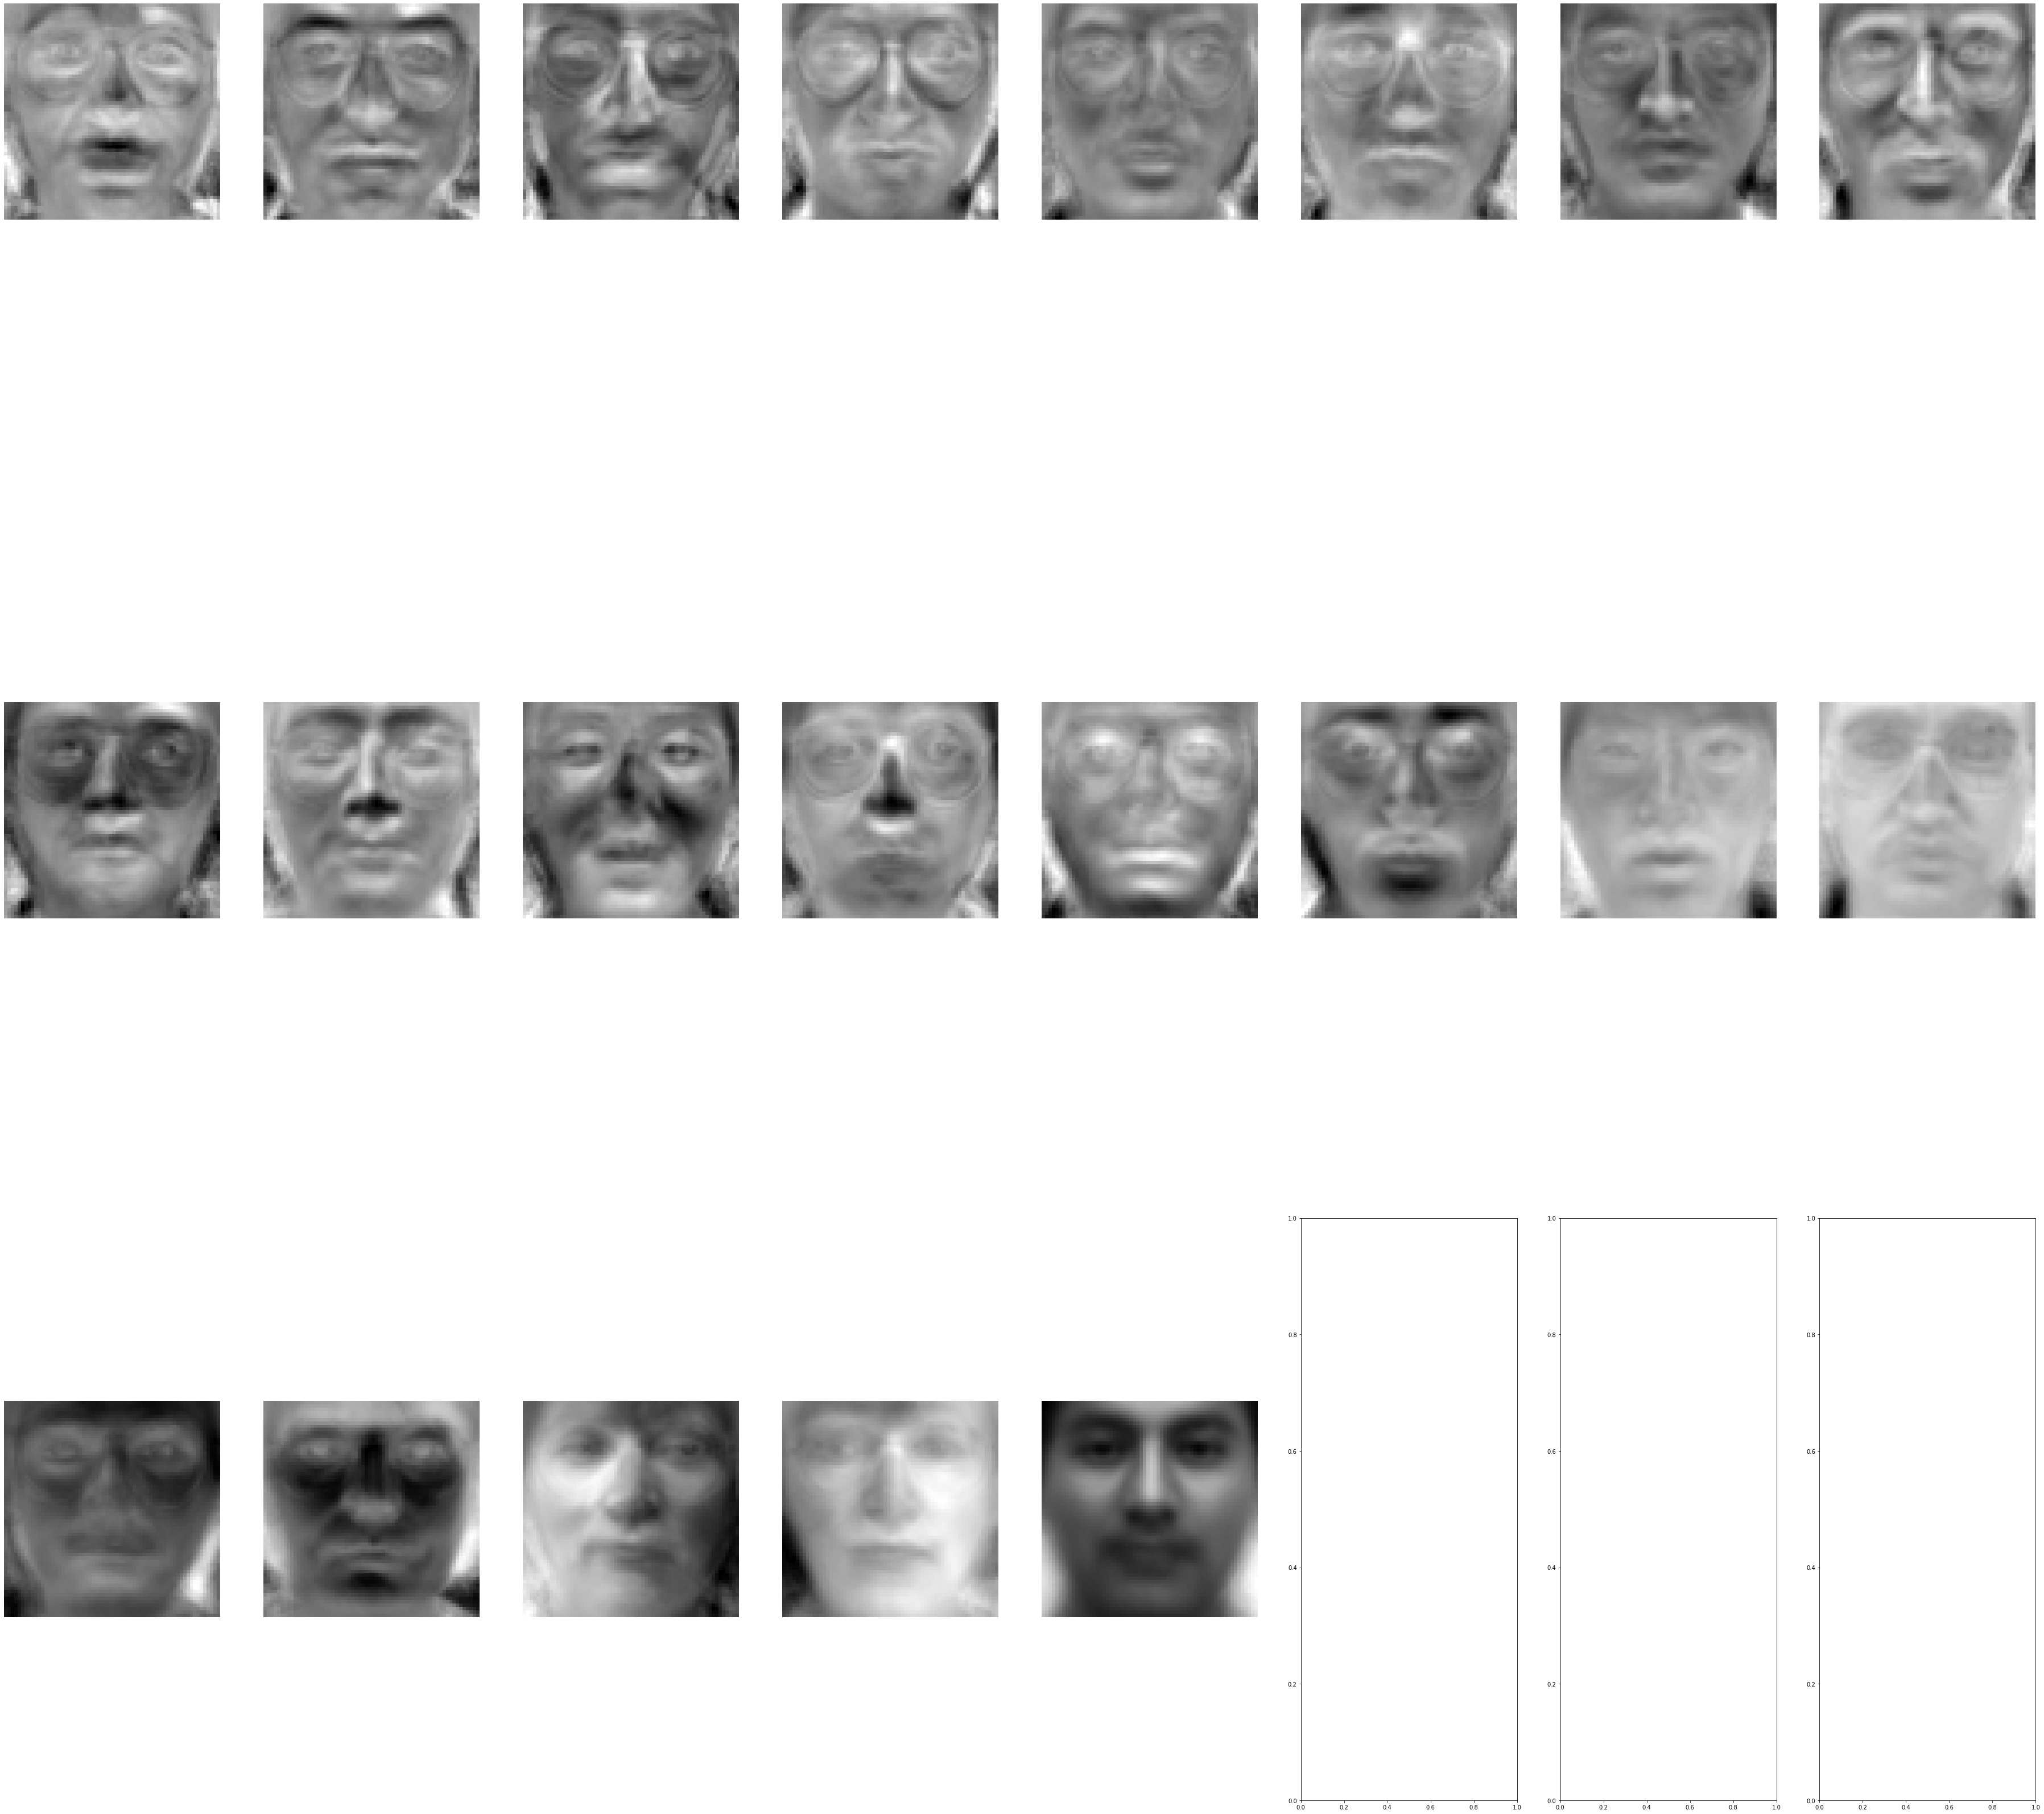

In [20]:
_,axs=plt.subplots(3,8,figsize=(64,64))
axs=axs.flatten()
for i in range(21):
    print_image(axs[i],eigenFaces.T[i])

### a) list all the low-dimensinal representations

In [21]:
normalized_data_test5 = preprocessing.normalize(test_X)
pca_test5=np.dot(normalized_data_test5.T, eigenFaces)
pca_test5

array([[-2.33139656e-01, -5.02560011e-01, -7.79261631e-02,
        -2.57847032e-01, -1.04381923e+00,  1.40357124e+00,
        -2.64236717e-01,  1.74635194e-01,  1.01038350e+00,
         1.16422924e-02, -7.39558146e-01, -1.00664852e-01,
         1.82373907e+00,  3.99861687e-01, -5.47671626e-01,
        -1.71609575e+00,  3.69634505e-01,  8.64663255e+00,
         6.89218273e+00,  1.39245469e+01, -5.55839162e-02],
       [ 1.14979257e+00, -3.88247712e-01,  9.46462016e-01,
        -9.64731682e-01, -3.39409406e-01,  1.63255671e+00,
        -7.71597763e-02, -1.69725632e+00,  3.69274321e-01,
         1.07874415e+00, -2.28122479e+00, -1.60381214e+00,
         1.27325387e+00, -5.82573176e-01, -2.19743380e-01,
        -1.86704674e+00, -5.74751415e-01,  1.09279146e+01,
         8.79329444e+00,  1.19852538e+01,  2.68057496e+00],
       [-1.03109700e-01,  4.09744229e-01,  2.24966285e-01,
         2.83088221e-01, -7.47869577e-01,  1.42191974e+00,
        -7.12973225e-02, -1.08562399e+00, -1.87983233e

### b) display all the reconstructed test image

In [ ]:
figure(figsize=(3, 5), dpi=80)
train_eigValInd=np.argsort(val_train)
train_index=np.argsort(val_train)
k_index=train_index[-21:]
eigenFaces=vec_train[:,k_index]
_,axs=plt.subplots(3,8,figsize=(64,64))
axs=axs.flatten()
for i in range(21):
    print_image(axs[i],eigenFaces.T[i])

### c) evaluation criterion for measuring the loss between an original raw and reconstructed images
In PCA Reconstruction error is sum of eigen values of the ignored subspace. For example, we are selecting 21 first PC from 4096 dimensions, So reconstruction error is sum of 4096-21 eigen values of the ignored subspace

Calculating the reconstruction error means calculating the contribution of ignored eigenvalues which depends on the distribution of the data and how many components we are selecting.

### d) program the evaluation criterion 
since we already set the pov=0.9, then the reconstruction error is 1-0.9=0,1

## Part 4. Application: face recognition

In [22]:
train_X, train_y, test_X, test_y = np.load(f'./Data/Yale_64x64-part-4-persons.npy', allow_pickle=True)


In [23]:
h,w=train_X.shape
#get rows and colunmn numer of train_X
h,w 
# store the labels
n_classes=train_y.shape[0]

### a) 1. Establish SVM face recognition system with PCA

In [24]:
# import the models
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [26]:
# Train a SVM classification model with PCA
#Fitting the classifier to the training set
#use normalized data to do dot product 
normalized_data_train = preprocessing.normalize(train_X)
normalized_data_test = preprocessing.normalize(test_X)
#dot train data and eigenFaces
pca_train=np.dot(normalized_data_train.T, eigenFaces)
#dot test data and eigenFaces
pca_test=np.dot(normalized_data_test.T, eigenFaces)
#clf is SVC classifier
clf = SVC(kernel="rbf", random_state=2)
#fit the data and labels
clf = clf.fit(pca_train, train_y)
#predict the test data
y_pred_PCA = clf.predict(pca_test)

### a) 2. Establish SVM face recognition system without PCA

In [27]:
from sklearn import svm

# Train a SVM classification model
clf_SVC= SVC(kernel="rbf", random_state=2)
clf_SVC = clf.fit(train_X.T, train_y)


### b) 1. With PCA recognition accuracy and confusion matrix

In [28]:
print(classification_report(test_y, y_pred_PCA))
print("The confusion matix is")
print(confusion_matrix(test_y, y_pred_PCA))
print("The accuracy score is")
print(accuracy_score(test_y, y_pred_PCA))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80        12
           1       0.75      1.00      0.86        12

    accuracy                           0.83        24
   macro avg       0.88      0.83      0.83        24
weighted avg       0.88      0.83      0.83        24

The confusion matix is
[[ 8  4]
 [ 0 12]]
The accuracy score is
0.8333333333333334


### b) 2. SVM recognition accuracy and confusion matrix

In [31]:
y_pred = clf_SVC.predict(test_X.T)
print(classification_report(test_y, y_pred))
print("The confusion matix is")
print(confusion_matrix(test_y, y_pred))
print("The accuracy score is")
accuracy_score(test_y, y_pred)

              precision    recall  f1-score   support

           0       1.00      0.67      0.80        12
           1       0.75      1.00      0.86        12

    accuracy                           0.83        24
   macro avg       0.88      0.83      0.83        24
weighted avg       0.88      0.83      0.83        24

The confusion matix is
[[ 8  4]
 [ 0 12]]
The accuracy score is


0.8333333333333334